# Random Forest简介

随机森林是水文统计分析中常用的一种分类或回归算法，因此有必要了解其基本原理，以顺利读懂相关文献。

本文主要参考：

1. [说说随机森林](https://zhuanlan.zhihu.com/p/22097796)
2. [周志华《Machine Learning》学习笔记(10)--集成学习](https://github.com/Vay-keen/Machine-learning-learning-notes/blob/master/%E5%91%A8%E5%BF%97%E5%8D%8E%E3%80%8AMachine%20Learning%E3%80%8B%E5%AD%A6%E4%B9%A0%E7%AC%94%E8%AE%B0(10)--%E9%9B%86%E6%88%90%E5%AD%A6%E4%B9%A0.md)
3. [理解随机森林：基于Python的实现和解释](https://www.jiqizhixin.com/articles/2018-12-22-3)
4. [Random Forest Tutorial.ipynb](https://github.com/TryEnlight/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb)
5. [随机森林回归 sklearn.ensemble.RandomForestRegressor](https://blog.csdn.net/GitzLiu/article/details/81952712)
6. [从零实现回归随机森林](https://zhuanlan.zhihu.com/p/52052903)
7. [利用随机森林对特征重要性进行评估](https://blog.csdn.net/zjuPeco/article/details/77371645)

## 基本概念

随机森林顾名思义，是用随机的方式建立一个森林，森林里面有很多的决策树组成，随机森林的每一棵决策树（关于决策树相关的基础也可参考本目录下的CART一文）之间是没有关联的。

决策树实际上是将空间用超平面进行划分的一种方法，每次分割的时候，都将当前的空间一分为二（图来自参考1）。
![DT](fbed6853d3c557892dc735960eb7f56e_hd.png)
![sample_space](bd9d3fe215ad812ddd3ca7133251b38a_hd.png)


决策树代码示例如下：

Decision tree has 9 nodes with maximum depth 3.
Model Accuracy: 1.0


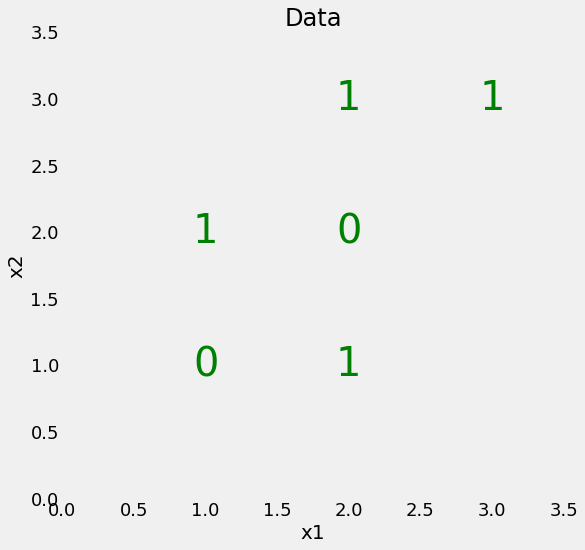

In [2]:
import numpy as np
import pandas as pd

# Set random seed to ensure reproducible runs
RSEED = 50

X = np.array([[2, 2], 
              [2, 1],
              [2, 3], 
              [1, 2], 
              [1, 1],
              [3, 3]])

y = np.array([0, 1, 1, 1, 0, 1])

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.figure(figsize = (8, 8))

# Plot each point as the label
for x1, x2, label in zip(X[:, 0], X[:, 1], y):
    plt.text(x1, x2, str(label), fontsize = 40, color = 'g',
             ha='center', va='center')
    
# Plot formatting
plt.grid(None);
plt.xlim((0, 3.5));
plt.ylim((0, 3.5));
plt.xlabel('x1', size = 20); plt.ylabel('x2', size = 20); plt.title('Data', size = 24)

from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=RSEED)
tree.fit(X, y)


print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')
print(f'Model Accuracy: {tree.score(X, y)}')

在得到森林之后，当有**一个新的输入样本进入**的时候，就让森林中的**每一棵决策树分别进行一下判断**，看看这个样本应该属于哪一类（对于分类算法），然后**看看哪一类被选择最多**，就预测这个样本为那一类。

随机森林可以既可以处理属性为离散值的量，比如ID3算法，也可以处理属性为连续值的量，比如C4.5算法。另外，随机森林还可以用来进行无监督学习聚类和异常点检测。

随机森林实际上属于“集成学习”的范畴，集成学习（ensemble learning）指的是将多个学习器进行有效地结合，组建一个“学习器委员会”，其中每个学习器担任委员会成员并行使投票表决权，使得委员会最后的决定更能够四方造福普度众生~...~，即其泛化性能要能优于其中任何一个学习器。

集成学习的基本结构为：先产生一组个体学习器，再使用某种策略将它们结合在一起。
![集成学习](68747470733a2f2f692e6c6f6c692e6e65742f323031382f31302f31382f356263383464306331353638332e706e67.png)
若个体学习器都属于同一类别，例如都是决策树或都是神经网络，则称该集成为同质的（homogeneous）;若个体学习器包含多种类型的学习算法，例如既有决策树又有神经网络，则称该集成为异质的（heterogenous）。同质集成：个体学习器称为“基学习器”（base learner），对应的学习算法为“基学习算法”（base learning algorithm）。 异质集成：个体学习器称为“组件学习器”（component learner）或直称为“个体学习器”。

虽说团结力量大但也有木桶短板理论调皮捣蛋，那如何做到呢？这就引出了集成学习的两个重要概念：准确性和多样性（diversity）。准确性指的是个体学习器不能太差，要有一定的准确度；多样性则是个体学习器之间的输出要具有差异性。**产生“好而不同”的个体学习器**正是集成学习研究的核心。

比如考虑二分类的简单情形，假设基分类器(输出为$h_i (x)$)之间相互独立（能提供较高的差异度），且错误率相等为 ε，则可以将集成器的预测H(x)看做一个伯努利实验，易知当所有基分类器中不足一半预测正确的情况下，集成器预测错误，所以集成器的错误率可以计算为：
$$H(x)=sign(\sum _{T}^{i=1}h_i(x))$$
$$P(H(x)\neq f(x))=\sum _{k=0}^{\lfloor T/2\rfloor}C_T^k (1-\epsilon)^k\epsilon ^{T-k}\le exp(-\frac1 2 T(1-2\epsilon)^2)$$

这里是以RF为主，因此就只讨论RF，其余的如Boosting和Bagging，后续用到再讨论。

## 算法内容

RF的基本思（tao）想（lu）是通过“自助采样”的方法来增加多样性。它的基学习器固定为决策树，多棵树也就组成了森林，而“随机”则在于**选择划分属性的随机**，随机森林在训练基学习器时，也采用**有放回采样的方式添加样本扰动**，同时它还**引入了一种属性扰动**，即在基决策树的训练过程中，**在选择划分属性时，RF先从候选属性集中随机挑选出一个包含K个属性的子集，再从这个子集中选择最优划分属性**，一般推荐K=log2（d）。

这样随机森林中基学习器的多样性不仅来自样本扰动，还来自属性扰动，从而进一步提升了基学习器之间的差异度。随机森林的**起始性能较差**（由于属性扰动，基决策树的准确度有所下降），但随着基学习器数目的增多，随机森林往往**会收敛到更低的泛化误差**。

### 随机采样

随机森林的一大关键是每个树都在随机的数据点样本上进行训练。这些样本是可重复地抽取出来的（称为 bootstrapping），也就是说某些样本会多次用于单个树的训练（如果有需要，也可以禁止这种做法）。其思路是，**通过在不同样本上训练每个树，尽管每个树依据训练数据的某个特定子集而可能有较高方差，但整体而言整个森林的方差会很低**。这种在数据的不同子集上训练每个单个学习器然后再求预测结果的平均的流程被称为 bagging，这是 bootstrap aggregating 的缩写。

### 特征的随机子集

随机森林背后的另一个概念是：**在每个决策树中，分割每个节点时都只会考虑所有特征中的一个子集**。通常设定为 sqrt(n_features)，意思是在每个节点，决策树会基于一部分特征来考虑分割，这部分特征的数量为总特征数量的平方根。随机森林也可以在每个节点考虑所有特征来进行训练。（在 Scikit-Learn 随机森林实现中，这些选项是可调控的。）

如果你理解了单个决策树、bagging 决策树、特征的随机子集，那你就可以很好地理解随机森林的工作方式了。随机森林组合了数百或数千个决策树，并会在稍有不同的观察集上训练每个决策树（数据点是可重复地抽取出来的），并且会根据限定数量的特征分割每个树中的节点。随机森林的最终预测结果是每个单个树的预测结果的平均。

In [3]:
from sklearn.ensemble import RandomForestRegressor
 
data=[[0,0,0],[1,1,1],[2,2,2]]
 
target=[0,1,2]
 
rfr=RandomForestRegressor()
 
rfr.fit(data,target)   #训练数据
 
print(rfr.predict([[1,1,1]]))    #预测数据

print(rfr.predict([[1,1,1],[2,2,2]]))

[0.3]
[0.3 1.6]


E:\Programs\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## 特征重要性

现实情况下，一个数据集中往往有成百上前个特征，如何在其中选择比结果影响最大的那几个特征，以此来缩减建立模型时的特征数是我们比较关心的问题。这样的方法其实很多，比如主成分分析PCA（可见本文件夹下另一篇记录），lasso等等。不过，这里只简单介绍用随机森林来对进行特征筛选。

feature importance,特征的重要性表示**特征对预测结果影响程度**，某一特征重要性越大，表明该特征对预测结果的影响越大，重要性越小，表明该特征对预测结果越小。RFR中某一特征的重要性，是**该特征在内部所有决策树重要性的平均值**，说白了就是看看每个特征在随机森林中的每颗树上做了多大的贡献，然后取个平均值，最后比一比特征之间的贡献大小。

那么这个贡献是怎么一个说法呢？通常可以用基尼指数（Gini index）或者袋外数据（OOB）错误率作为评价指标来衡量。

在决策树中，计算某一个特征的重要性有多种方法，sklearn内部采用的方法如下：

某一节点 k 的重要性为
$$n_k=\omega_k*G_k-\omega_{left}*G_{left}-\omega_{right}*G_{right}$$

其中，$\omega_k,\omega_{left},\omega_{right}$分别为**节点k以及其左右子节点中训练样本个数与总训练样本数目的比例**， $G_k,G_{left},G_{right}$分为**节点 k以及其左右子节点的不纯度**。知道每一个节点的重要性之后，即可通过公式得出某一feature的重要性:
$$f_i=\frac{\sum_{j\in nodes\ split\ on\ feature\ i}n_j}{\sum_{k\in\ all\ nodes}n_k}$$

In [6]:
import pandas as pd
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
df = pd.read_csv(url, header = None)
df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
              'Alcalinity of ash', 'Magnesium', 'Total phenols', 
              'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
              'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

import numpy as np
np.unique(df['Class label'])

df.info()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
x, y = df.iloc[:, 1:].values, df.iloc[:, 0].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
feat_labels = df.columns[1:]
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(x_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
Class label                     178 non-null int64
Alcohol                         178 non-null float64
Malic acid                      178 non-null float64
Ash                             178 non-null float64
Alcalinity of ash               178 non-null float64
Magnesium                       178 non-null int64
Total phenols                   178 non-null float64
Flavanoids                      178 non-null float64
Nonflavanoid phenols            178 non-null float64
Proanthocyanins                 178 non-null float64
Color intensity                 178 non-null float64
Hue                             178 non-null float64
OD280/OD315 of diluted wines    178 non-null float64
Proline                         178 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.6 KB
 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids     